# Hyperparamters



In [ ]:
random_state = 42
eta0 = 5
alpha = 0.51
batchsize = 4
num_test = 5
iterations = 10000

# Import All Pacakges Needed

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from autograd import grad
from autograd.scipy import stats
from scipy import optimize
import autograd.numpy as np
from astropy.stats import circvar

Mounted at /content/mydrive


## utils

In [ ]:
def generate_gaussian_blobs(n_samples_per_blob, means, covariances, label = [1,-1]):
    all_blobs = []
    labels = []

    for i in range(len(means)):
        n_samples = n_samples_per_blob[i]
        mean = means[i]
        np.random.seed(random_state)
        blobs = np.random.multivariate_normal(mean, covariances, n_samples)
        all_blobs.append(blobs)
        labels += n_samples*[label[i]]

    result = pd.DataFrame(np.vstack(all_blobs))
    result['labels'] = labels
    return result


def is_linearly_separable(X, y):
    linear_svc = LinearSVC(fit_intercept=False,
                           dual = False,
                           C=1e20)
    linear_svc.fit(X, y)
    y_pred = linear_svc.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print(f"The data is linearly separable: {accuracy == 1.0}\t")
    return linear_svc.coef_[0]


def _loss(beta, Y, Z, loss_type):
    preds = np.dot(Z,beta)

    if loss_type == 'probit':

      probit = stats.norm.cdf(Y * preds)
      probit = np.clip(probit, 1e-10, 1 - 1e-10)
      loss = -np.log(probit)

    elif loss_type == 'hinge':
      loss = np.square(np.maximum(0, 1 - Y * preds))

    elif loss_type == 'logistic':
      loss = np.log(1 + np.exp(-Y * preds))

    else:
      raise ValueError('loss type not defined')

    return loss


def make_sgd_robust_loss(Y, Z, loss_type):
    N = Y.size
    sgd_loss = lambda param, inds: np.mean(_loss(param, Y[inds], Z[inds], loss_type)) #+ np.sum(param**2)/(2*N)
    grad_sgd_loss = grad(sgd_loss)
    return sgd_loss, grad_sgd_loss


def integer_generator(batch_size, sample_size):
    numbers = list(range(sample_size))
    while True:
        random.shuffle(numbers)
        for i in range(0, len(numbers), batch_size):
            yield numbers[i:i + batch_size]


def run_SGD_modified(strategy, sgd_loss, grad_loss, init_param, eta , eta0, alpha, batchsize, N, iterations, replacement = True):
    D = init_param.size
    parameters = np.zeros((iterations+1,D))
    parameters[0] = init_param
    sampler = integer_generator(batchsize, N)
    losses = []

    for k in range(iterations):
        if replacement:
            inds = np.random.choice(N, batchsize)
        else:
            inds = next(sampler)

        if strategy == 'constant' or strategy == 'average':
            stepsize = eta

        elif strategy == 'decreasing':
            stepsize = eta0 / (k+1)**alpha

        losses.append(sgd_loss(parameters[k], inds))
        #momentum = grad_loss if momentum is None else momentum*0.9 + grad_loss*0.1
        parameters[k+1] = parameters[k] - stepsize *  grad_loss(parameters[k], inds)

    if strategy == 'average':
      return np.array([np.mean(parameters[i//2:i+1], axis=0) for i in range(iterations)]),losses

    return parameters[1:],losses


def angular_variance_astropy(vectors):
    angles = np.arctan2(vectors[:, 1], vectors[:, 0])
    return circvar(angles, axis=0)


def plot_results(Z, results, max_margin_vectors, losses, length, labels, prefix, title, normalize_loss = False, clamped = False):
    total_sizes = []
    total_angles = []
    total_variances = []
    pbar = tqdm(enumerate(results), total=len(results))

    for i, result in pbar:
      sizes = []
      angles = []
      variances = []
      pbar.set_description(desc = f"Currently Processing {i}th Iteration")
      if isinstance(max_margin_vectors,list):
        max_margin_vector = max_margin_vectors[i]
      else:
        max_margin_vector = max_margin_vectors

      for i, res in enumerate(result):
        last_vector_norm = np.linalg.norm(res[-1])
        norm_margin_vector = max_margin_vector/np.linalg.norm(max_margin_vector)
        norms_results = np.linalg.norm(res, axis=1)
        norms_results_dim = np.linalg.norm(res, axis=1, keepdims = True)
        norm_max_margin = np.linalg.norm(max_margin_vector)
        size = np.linalg.norm(res/last_vector_norm, axis=1)
        angle = 1- np.dot(res, max_margin_vector)/(norms_results*norm_max_margin)
        variance = [angular_variance_astropy(res[:i+1]) for i in range(1, len(res))]
        # margin = np.linalg.norm(res/norms_results_dim - max_margin_vector/norm_max_margin, axis = 1)

        sizes.append(size)
        angles.append(angle)
        variances.append(variance)

      total_sizes.append(np.mean(np.array(sizes),axis = 0))
      total_angles.append(np.mean(np.array(angles),axis = 0))
      total_variances.append(np.mean(np.array(variances),axis = 0))

    data_sizes = np.array(total_sizes)

    if normalize_loss:
      losses = np.array(losses)
      first = losses[:, :, 0]
      first_reshape = first[:, :, np.newaxis]
      data_losses = np.mean(losses / first_reshape, axis = 1)
    else:
      data_losses = np.mean(np.array(losses), axis = 1)

    data_sizes = np.array(total_sizes)
    data_angles = np.array(total_angles)
    data_variances = np.array(total_variances)

    df_sizes = pd.DataFrame(data_sizes.T, columns=[f'{prefix}: {labels[i]}' for i in range(data_sizes.shape[0])])
    df_losses = pd.DataFrame(data_losses.T, columns=[f'{prefix}: {labels[i]}' for i in range(data_losses.shape[0])])
    df_angles = pd.DataFrame(data_angles.T, columns=[f'{prefix}: {labels[i]}' for i in range(data_angles.shape[0])])
    df_variances = pd.DataFrame(data_variances.T, columns=[f'{prefix}: {labels[i]}' for i in range(data_variances.shape[0])])

    df_sizes['Index'] = np.arange(1, length + 1)
    df_losses['Index'] = np.arange(1, length + 1)
    df_angles['Index'] = np.arange(1, length + 1)
    df_variances['Index'] = np.arange(1, length)

    df_sizes = pd.melt(df_sizes, id_vars='Index', var_name='Line', value_name='Value')
    df_losses = pd.melt(df_losses, id_vars='Index', var_name='Line', value_name='Value')
    df_angles = pd.melt(df_angles, id_vars='Index', var_name='Line', value_name='Value')
    df_variances = pd.melt(df_variances, id_vars='Index', var_name='Line', value_name='Value')

    print('\n\n\n\n')
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    #fig.suptitle(title, fontsize=20)

    for ax in axs.flat:
      formatter = mticker.ScalarFormatter(useMathText=True)
      formatter.set_scientific(True)
      formatter.set_powerlimits((-1, 1))
      ax.yaxis.set_major_formatter(formatter)

    sns.lineplot(data=df_sizes, x='Index', y='Value', hue='Line', ax = axs[0][0])
    axs[0][0].set_xscale('log')
    axs[0][0].set_xlabel('Iterations (t)', fontsize=17)
    axs[0][0].set_ylabel('Mean Normalized W(t)', fontsize=17)
    axs[0][0].tick_params(axis='both', which='major', labelsize=15)
    axs[0][0].tick_params(axis='both', which='minor', labelsize=9)
    axs[0][0].legend()

    sns.lineplot(data=df_losses, x='Index', y='Value', hue='Line', ax = axs[0][1])
    axs[0][1].set_xscale('log')
    axs[0][1].set_yscale('log')
    axs[0][1].set_xlabel('Iterations (t)', fontsize=17)
    axs[0][1].set_ylabel('Mean L(W(t))', fontsize=17)
    axs[0][1].tick_params(axis='both', which='major', labelsize=15)
    axs[0][1].tick_params(axis='both', which='minor', labelsize=9)
    axs[0][1].legend()
    if clamped:
      _, ymax = axs[0][1].get_ylim()
      ymin = 0.000000001
      axs[0][1].set_ylim(ymin, ymax)

    sns.lineplot(data=df_angles, x='Index', y='Value', hue='Line', ax = axs[1][0])
    axs[1][0].set_xscale('log')
    axs[1][0].set_xlabel('Iterations (t)', fontsize=17)
    axs[1][0].set_ylabel('Mean Angle Gap', fontsize=17)
    axs[1][0].tick_params(axis='both', which='major', labelsize=15)
    axs[1][0].tick_params(axis='both', which='minor', labelsize=9)
    axs[1][0].legend()

    sns.lineplot(data=df_variances, x='Index', y='Value', hue='Line', ax = axs[1][1])
    axs[1][1].set_xscale('log')
    axs[1][1].set_xlabel('Iterations (t)', fontsize=17)
    axs[1][1].set_ylabel('Mean Circular Variance', fontsize=17)
    axs[1][1].tick_params(axis='both', which='major', labelsize=15)
    axs[1][1].tick_params(axis='both', which='minor', labelsize=9)
    axs[1][1].legend()

    plt.savefig(f'{prefix}.pdf',dpi = 300, bbox_inches='tight')

# Original Synthetic Data Generation

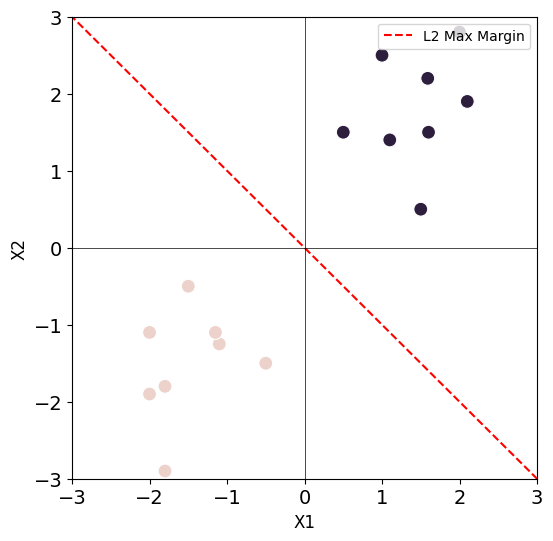

In [ ]:
xs = [(0.5, 1.5,1),
      (1.5, 0.5,1),
      (1.4, 1.1,1),
      (1.5, 1.6,1),
      (1.9, 2.1,1),
      (2.2, 1.59,1),
      (2.5, 1.0,1),
      (2.8, 2.0,1),
      (-0.5, -1.5,-1),
      (-1.5, -0.5,-1),
      (-1.25, -1.1,-1),
      (-1.1, -2.0,-1),
      (-1.1, -1.15,-1),
      (-1.8,-1.8,-1),
      (-1.9,-2.0,-1),
      (-2.9,-1.8,-1)]

df = pd.DataFrame(xs,columns = [0,1,'labels'])
L2_max_margin = np.array([1,1])

plt.figure(figsize=(6, 6))
#visualize data
sns.scatterplot(x=1, y = 0, hue = 'labels', data = df, legend = False, s=100)

# Plotting the decision boundary
x_values = np.linspace(-10, 10, 100)
y_values = -(L2_max_margin[0] / L2_max_margin[1]) * x_values
plt.plot(x_values, y_values, label="L2 Max Margin", color = 'red',linestyle='--')
plt.legend()
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('X1',fontsize = 12)
plt.ylabel('X2',fontsize = 12)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.savefig('original_data.pdf',dpi = 300, bbox_inches='tight')

# Original Data: Batch Size

In [ ]:
Y, Z = df['labels'].values, df.iloc[:,:-1].values
_, singular_values, _ = np.linalg.svd(Z)

sgd_loss, grad_sgd_loss = make_sgd_robust_loss(Y, Z, 'logistic')
init_param = np.zeros(D)

def wrapper(param):
    return sgd_loss(param,np.array(range(16)))

opt_param=optimize.minimize(wrapper, init_param).x

In [ ]:
total_param = []
total_loss = []
batch_sizes = [1,2,4,8,16]

pbar = tqdm(enumerate(batch_sizes), total=len(batch_sizes))
for i, test_batchsize in pbar:
  pbar.set_description(desc = f"Currently Processing {i}th Iteration")

  all_param = []
  all_loss = []
  for _ in range(num_test):
    results, losses = run_SGD_modified('constant',
                                      sgd_loss,
                                      grad_sgd_loss,
                                      init_param,
                                      1/np.max(singular_values),
                                      eta0,
                                      alpha,
                                      test_batchsize,
                                      Z.shape[0],
                                      iterations,
                                      True)
    all_param.append(results)
    all_loss.append(losses)

  total_param.append(all_param)
  total_loss.append(all_loss)

Currently Processing 4th Iteration: 100%|██████████| 5/5 [01:37<00:00, 19.43s/it]


Currently Processing 4th Iteration: 100%|██████████| 5/5 [01:44<00:00, 20.97s/it]


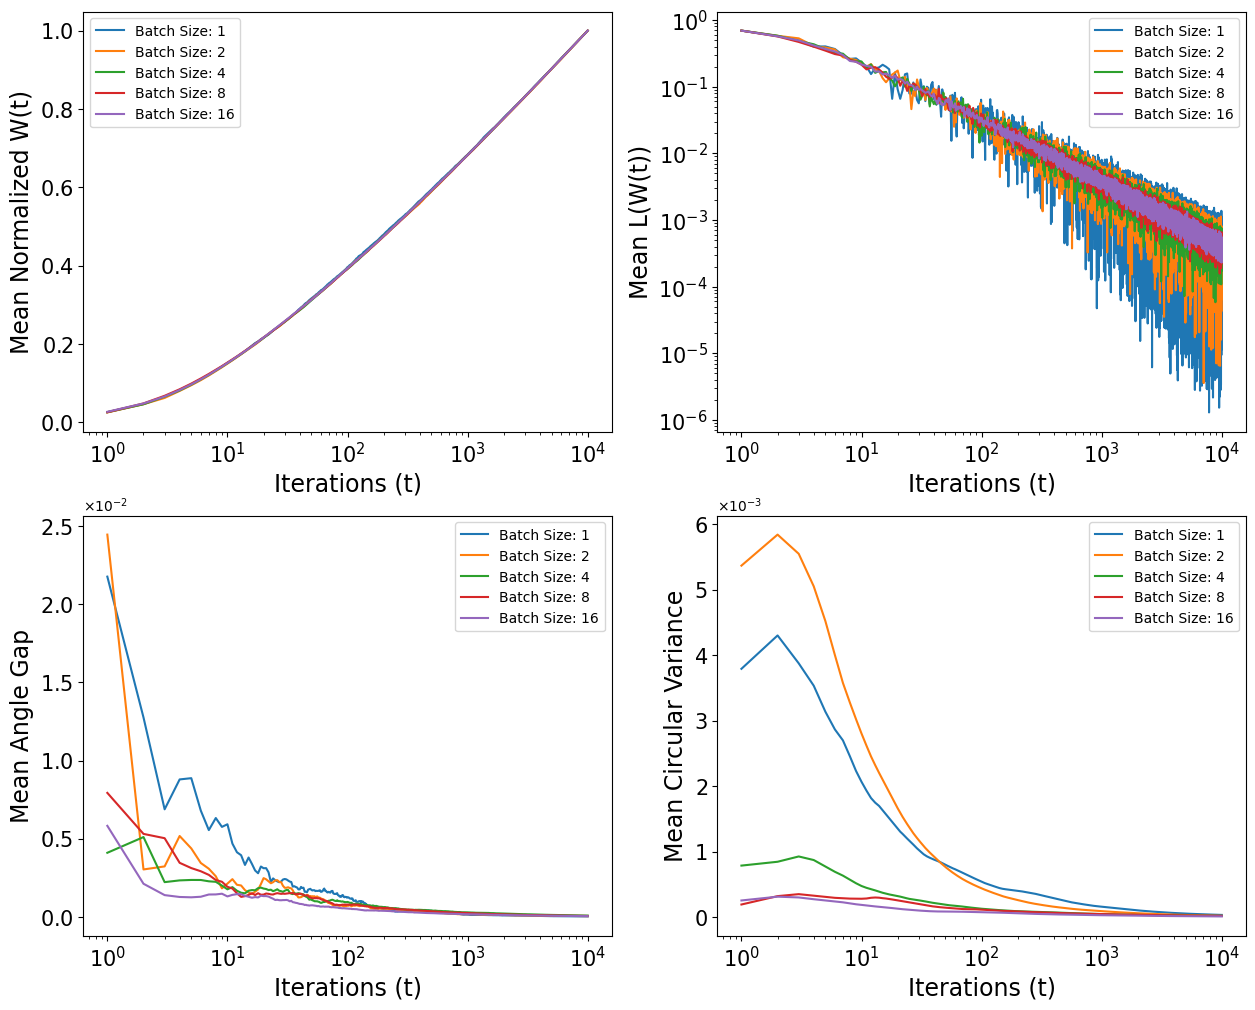

In [ ]:
plot_results(Z, total_param,
             L2_max_margin,
             total_loss, iterations,
             batch_sizes, 'Batch Size',
             'SGD under Original Synthetic Data with Different Batch Sizes')

# Original Data: Loss Function

In [ ]:
total_param = []
total_loss = []
loss_funcs = ['hinge','probit','logistic']

pbar = tqdm(enumerate(loss_funcs), total=len(loss_funcs))
for i, loss_func in pbar:
  test_sgd_loss, test_grad_sgd_loss = make_sgd_robust_loss(Y, Z, loss_func)
  pbar.set_description(desc = f"Currently Processing {i}th Iteration")

  all_param = []
  all_loss = []
  for _ in range(num_test):
    results, losses = run_SGD_modified('constant',
                                      test_sgd_loss,
                                      test_grad_sgd_loss,
                                      init_param,
                                      1/np.max(singular_values),
                                      eta0,
                                      alpha,
                                      batchsize,
                                      Z.shape[0],
                                      iterations,
                                      True)
    all_param.append(results)
    all_loss.append(losses)

  total_param.append(all_param)
  total_loss.append(all_loss)

Currently Processing 2th Iteration: 100%|██████████| 3/3 [01:28<00:00, 29.37s/it]


Currently Processing 2th Iteration: 100%|██████████| 3/3 [01:00<00:00, 20.18s/it]


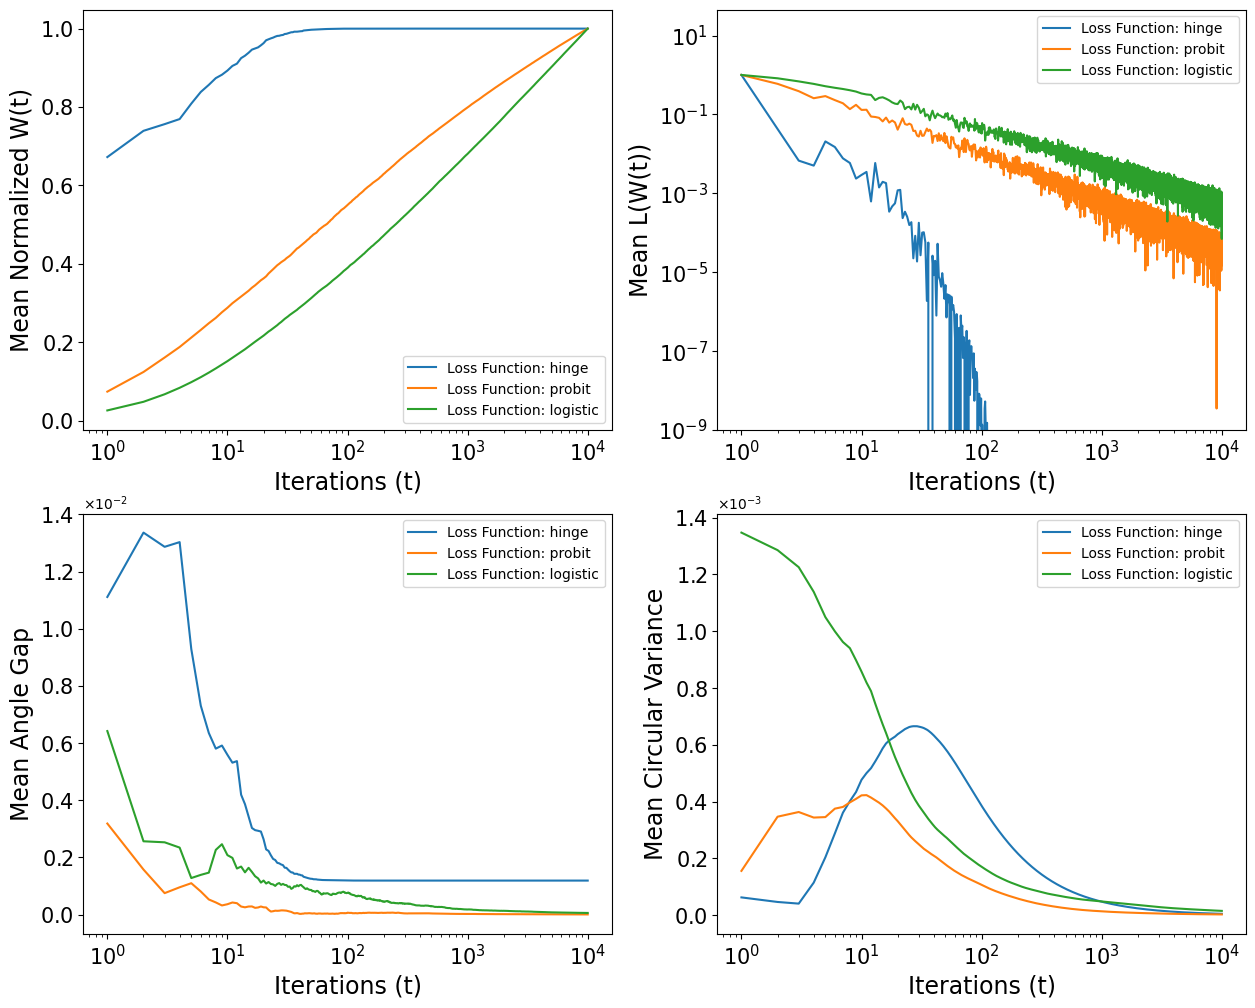

In [ ]:
plot_results(Z, total_param,
             L2_max_margin,
             total_loss, iterations,
             loss_funcs, 'Loss Function',
             'SGD under Original Synthetic Data with Different Loss Functions', True, True)

# Original Data: Learning Rate

In [ ]:
total_param = []
total_loss = []
learning_rates = [1.0,0.5,0.1,0.01,0.001]

pbar = tqdm(enumerate(learning_rates), total=len(learning_rates))
for i, test_learning_rate in pbar:
  pbar.set_description(desc = f"Currently Processing {i}th Iteration")

  all_param = []
  all_loss = []
  for _ in range(num_test):
    results, losses = run_SGD_modified('constant',
                                      sgd_loss,
                                      grad_sgd_loss,
                                      init_param,
                                      test_learning_rate,
                                      eta0,
                                      alpha,
                                      batchsize,
                                      Z.shape[0],
                                      iterations,
                                      True)
    all_param.append(results)
    all_loss.append(losses)

  total_param.append(all_param)
  total_loss.append(all_loss)

Currently Processing 4th Iteration: 100%|██████████| 5/5 [01:37<00:00, 19.53s/it]


Currently Processing 4th Iteration: 100%|██████████| 5/5 [01:45<00:00, 21.06s/it]


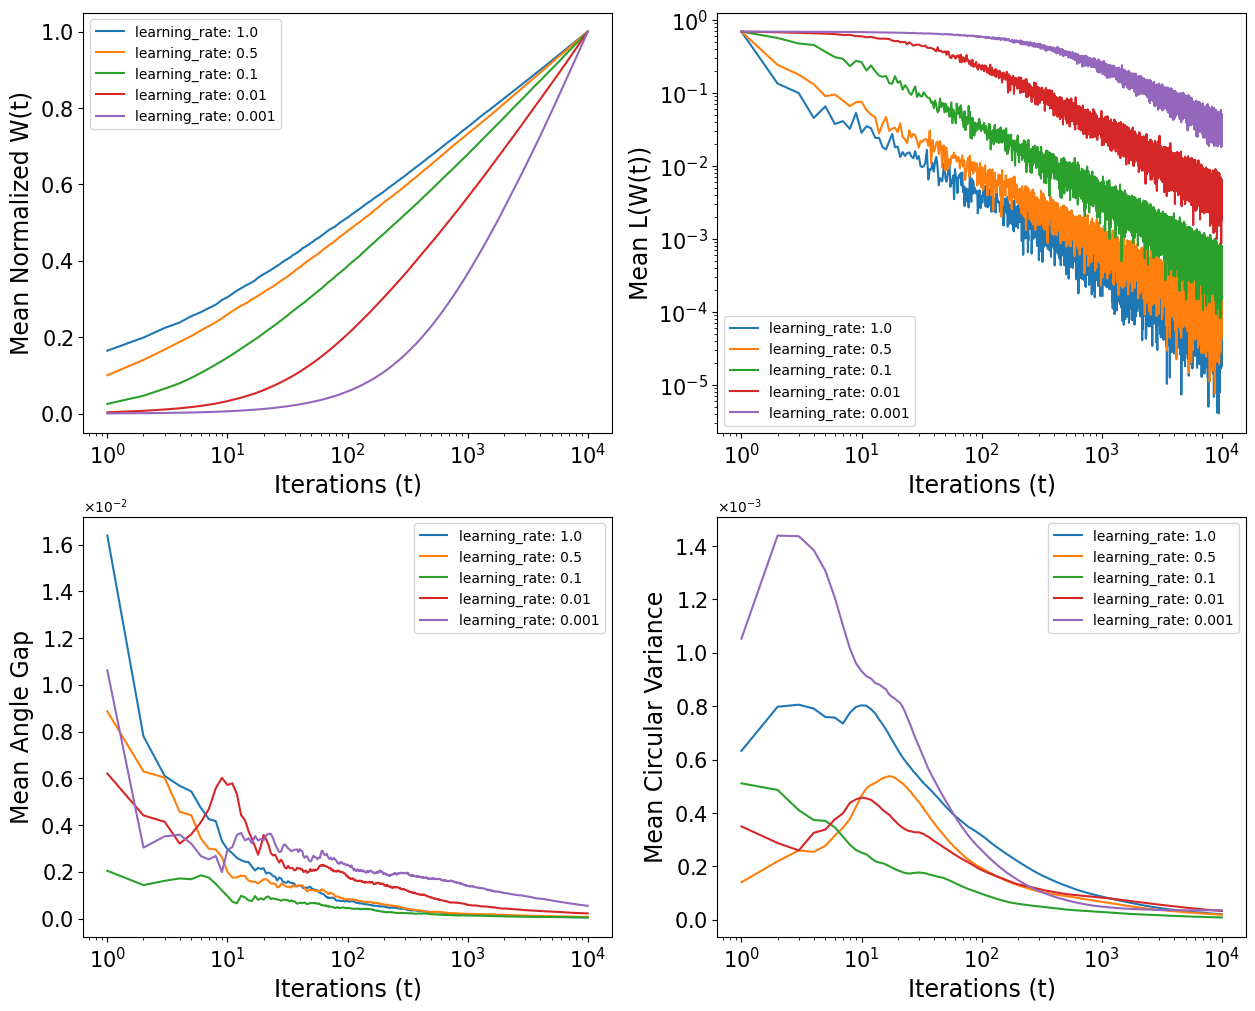

In [ ]:
plot_results(Z, total_param,
             L2_max_margin,
             total_loss, iterations,
             learning_rates, 'learning_rate',
             'SGD under Original Synthetic Data with Different Learning Rates')

# Gaussian Blob Synthetic Data Generation

The data is linearly separable: True	
The L2 max margin weight is [0.87562693 0.88564746]


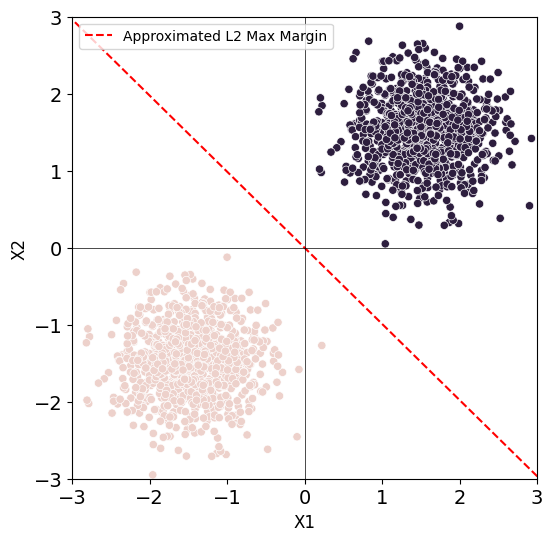

In [ ]:
n_samples_per_blob = [1000,1000]
D = 2
means = [[1.5]*D,[-1.5]*D]
covariances = np.identity(D)*0.2

df = generate_gaussian_blobs(n_samples_per_blob = n_samples_per_blob,
                             means = means,
                             covariances = covariances)

#check for linear separability and L2 Max Margin Vector
L2_max_margin = is_linearly_separable(df.iloc[:,:-1], df['labels'])
print(f"The L2 max margin weight is {L2_max_margin}")

plt.figure(figsize=(6, 6))
#visualize data
sns.scatterplot(x=1, y = 0, hue = 'labels', data = df, legend = False)

# Plotting the decision boundary
x_values = np.linspace(-10, 10, 100)
y_values = -(L2_max_margin[0] / L2_max_margin[1]) * x_values
plt.plot(x_values, y_values, label="Approximated L2 Max Margin", color = 'red',linestyle='--')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.xlabel('X1',fontsize = 12)
plt.ylabel('X2',fontsize = 12)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.savefig('new_data.pdf',dpi = 300, bbox_inches='tight')

# Gaussian Data: Batch Size

In [ ]:
Y, Z = df['labels'].values, df.iloc[:,:-1].values
_, singular_values, _ = np.linalg.svd(Z)

sgd_loss, grad_sgd_loss = make_sgd_robust_loss(Y, Z, 'logistic')
init_param = np.zeros(D)

def wrapper(param):
    return sgd_loss(param,np.array(range(16)))

opt_param=optimize.minimize(wrapper, init_param).x

In [ ]:
total_param = []
total_loss = []
batch_sizes = [8,16,32,64,128]

pbar = tqdm(enumerate(batch_sizes), total=len(batch_sizes))
for i, test_batchsize in pbar:
  pbar.set_description(desc = f"Currently Processing {i}th Iteration")

  all_param = []
  all_loss = []
  for _ in range(num_test):
    results, losses = run_SGD_modified('constant',
                                      sgd_loss,
                                      grad_sgd_loss,
                                      init_param,
                                      1/np.max(singular_values),
                                      eta0,
                                      alpha,
                                      test_batchsize,
                                      Z.shape[0],
                                      iterations,
                                      True)
    all_param.append(results)
    all_loss.append(losses)

  total_param.append(all_param)
  total_loss.append(all_loss)

Currently Processing 4th Iteration: 100%|██████████| 5/5 [01:37<00:00, 19.50s/it]


Currently Processing 4th Iteration: 100%|██████████| 5/5 [01:28<00:00, 17.78s/it]


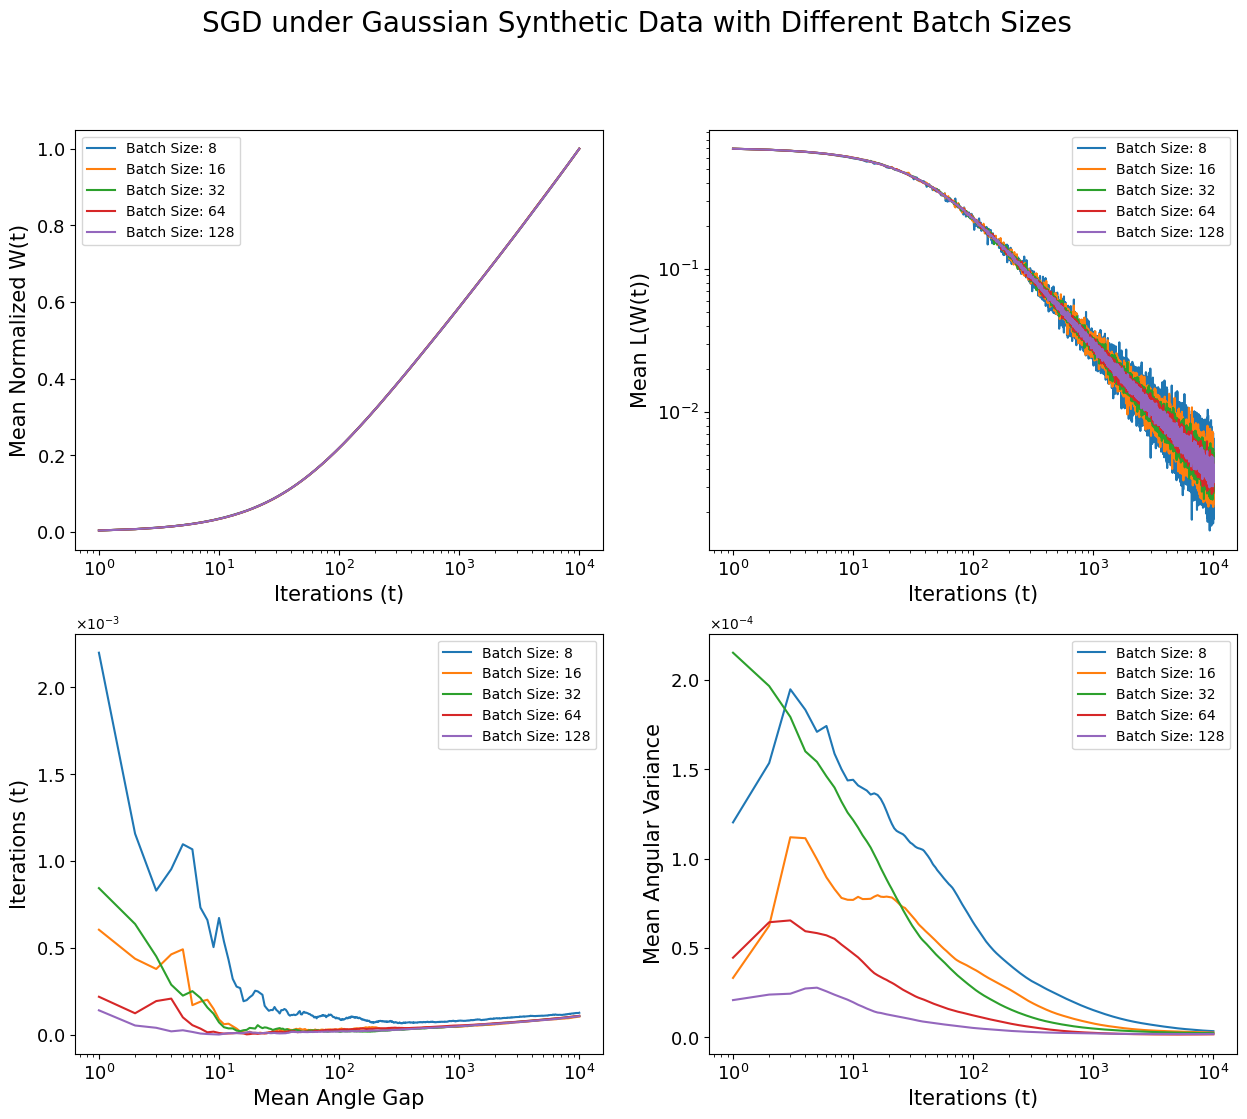

In [ ]:
plot_results(Z, total_param,
             L2_max_margin,
             total_loss, iterations,
             batch_sizes, 'Batch Size',
             'SGD under Gaussian Synthetic Data with Different Batch Sizes')

# Gaussian Data: Loss Function

In [ ]:
total_param = []
total_loss = []
loss_funcs = ['hinge','probit','logistic']

pbar = tqdm(enumerate(loss_funcs), total=len(loss_funcs))
for i, loss_func in pbar:
  test_sgd_loss, test_grad_sgd_loss = make_sgd_robust_loss(Y, Z, loss_func)
  pbar.set_description(desc = f"Currently Processing {i}th Iteration")

  all_param = []
  all_loss = []
  for _ in range(num_test):
    results, losses = run_SGD_modified('constant',
                                      test_sgd_loss,
                                      test_grad_sgd_loss,
                                      init_param,
                                      1/np.max(singular_values),
                                      eta0,
                                      alpha,
                                      batchsize,
                                      Z.shape[0],
                                      iterations,
                                      True)
    all_param.append(results)
    all_loss.append(losses)

  total_param.append(all_param)
  total_loss.append(all_loss)

Currently Processing 2th Iteration: 100%|██████████| 3/3 [01:28<00:00, 29.54s/it]


Currently Processing 2th Iteration: 100%|██████████| 3/3 [00:54<00:00, 18.06s/it]


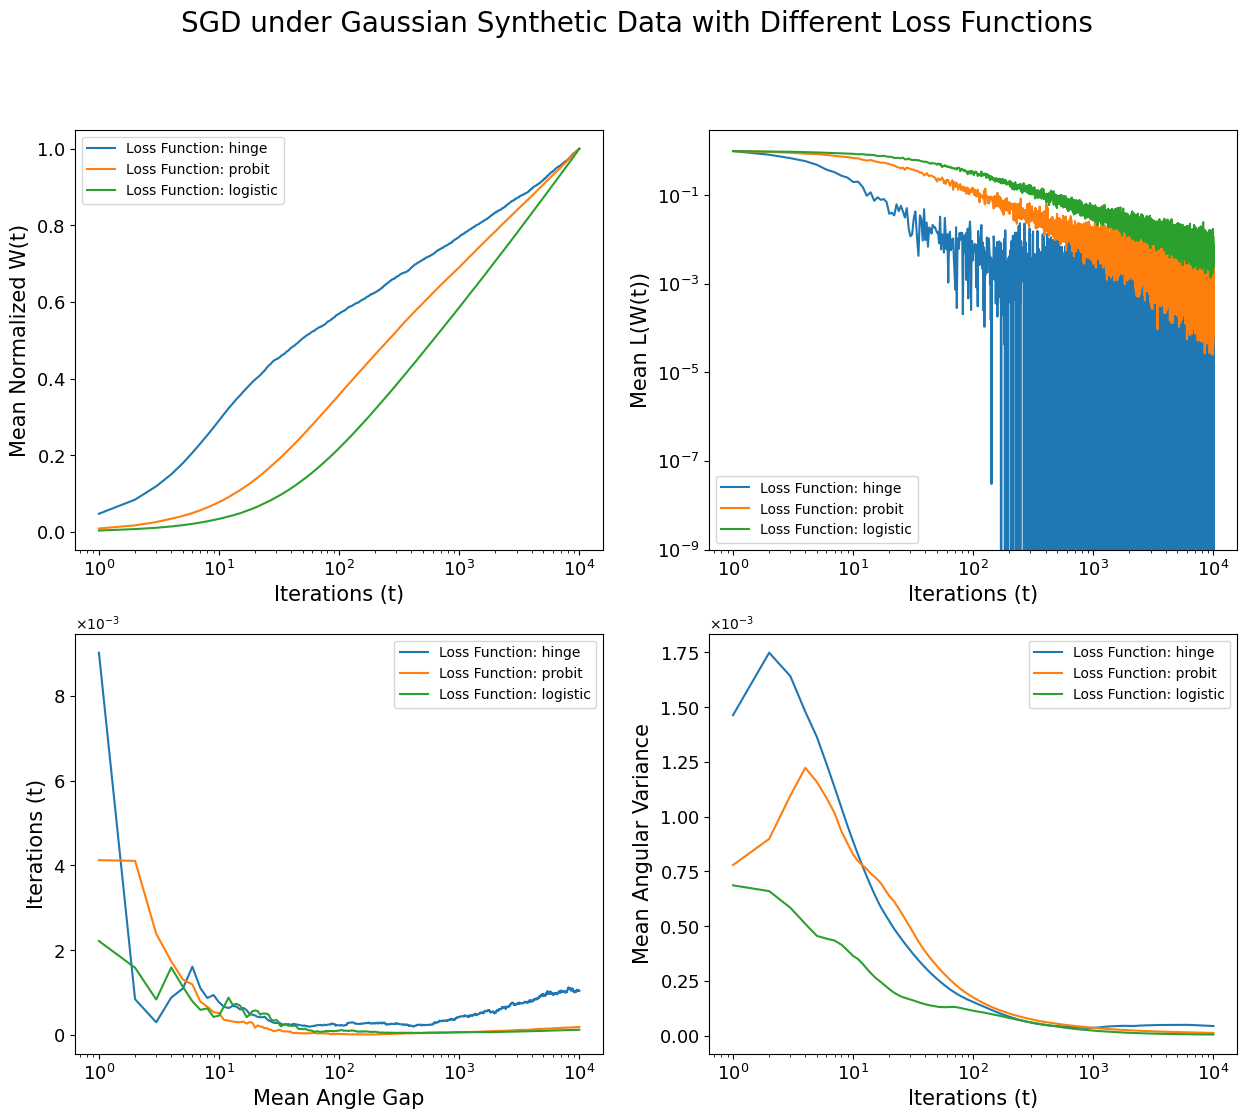

In [ ]:
plot_results(Z, total_param,
             L2_max_margin,
             total_loss, iterations,
             loss_funcs, 'Loss Function',
             'SGD under Gaussian Synthetic Data with Different Loss Functions', True, True)

# Gaussian Data: Learning Rate

In [ ]:
total_param = []
total_loss = []
learning_rates = [0.1,0.01,0.001,0.0001,0.00001,0.000001]

pbar = tqdm(enumerate(learning_rates), total=len(learning_rates))
for i, test_learning_rate in pbar:
  pbar.set_description(desc = f"Currently Processing {i}th Iteration")

  all_param = []
  all_loss = []
  for _ in range(num_test):
    results, losses = run_SGD_modified('constant',
                                      sgd_loss,
                                      grad_sgd_loss,
                                      init_param,
                                      test_learning_rate,
                                      eta0,
                                      alpha,
                                      batchsize,
                                      Z.shape[0],
                                      iterations,
                                      True)
    all_param.append(results)
    all_loss.append(losses)

  total_param.append(all_param)
  total_loss.append(all_loss)

Currently Processing 5th Iteration: 100%|██████████| 6/6 [01:54<00:00, 19.03s/it]


Currently Processing 5th Iteration: 100%|██████████| 6/6 [01:49<00:00, 18.17s/it]


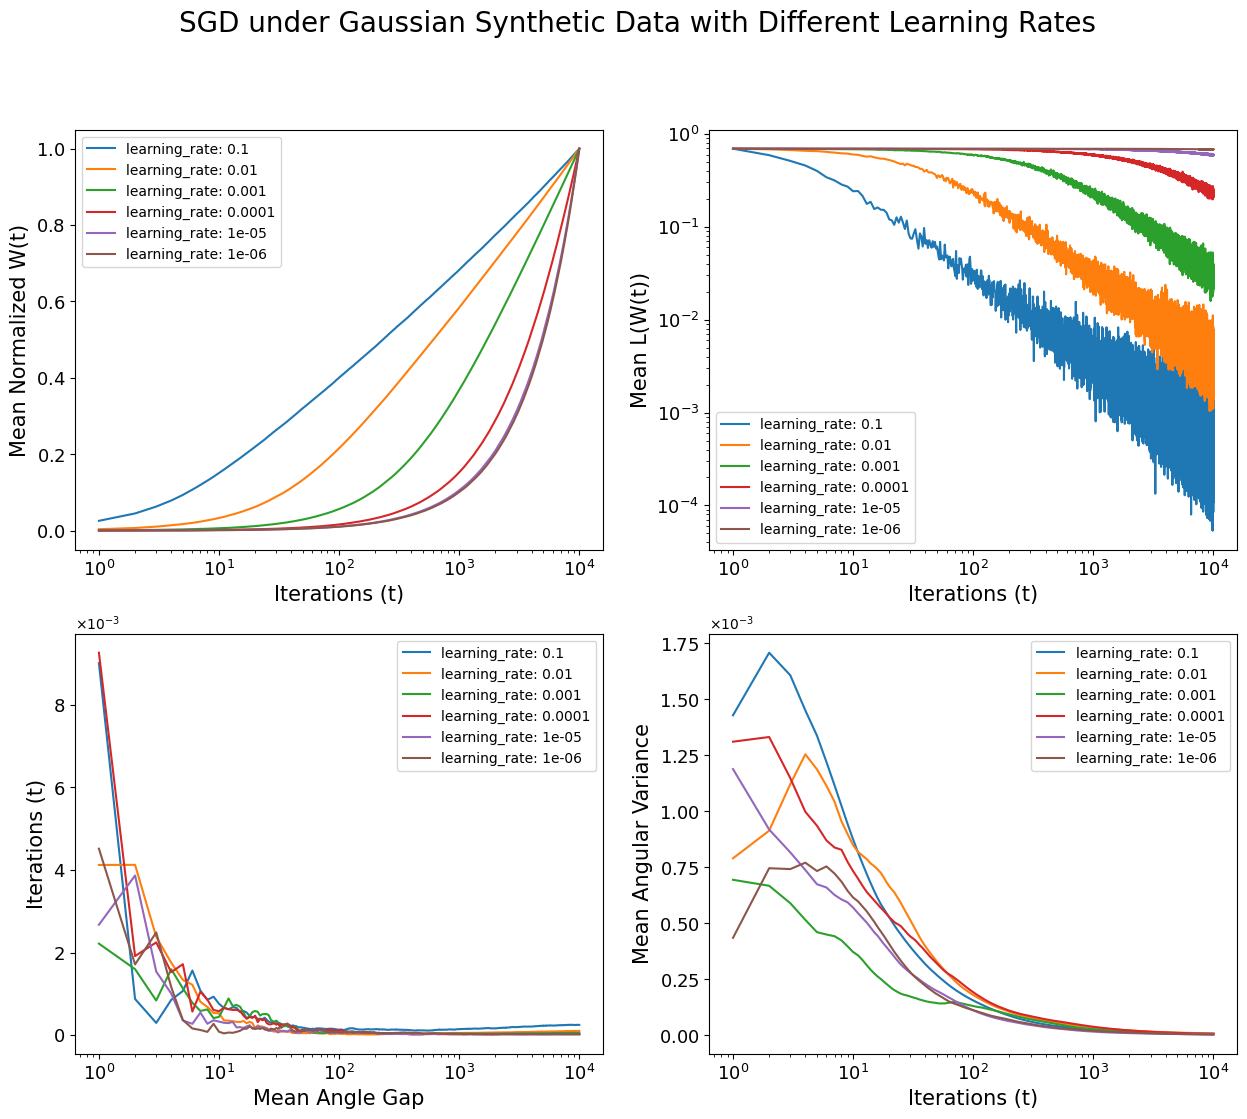

In [ ]:
plot_results(Z, total_param,
             L2_max_margin,
             total_loss, iterations,
             learning_rates, 'learning_rate',
             'SGD under Gaussian Synthetic Data with Different Learning Rates')

In [ ]:
total_param = []
total_loss = []
max_margin_vectors = []
dimensions = [2,4,8,16,32,64]

pbar = tqdm(enumerate(dimensions), total=len(dimensions))
for i, test_dimension in pbar:
  pbar.set_description(desc = f"Currently Processing {i}th Iteration")
  test_means = [[1.5]*test_dimension,[-1.5]*test_dimension]
  test_covariances = np.identity(test_dimension)*0.2
  test_df = generate_gaussian_blobs(n_samples_per_blob = n_samples_per_blob,
                                    means = test_means,
                                    covariances = test_covariances)

  #check for linear separability and L2 Max Margin Vector
  L2_max_margin = is_linearly_separable(test_df.iloc[:,:-1], test_df['labels'])
  max_margin_vectors.append(L2_max_margin)
  print(f"The test L2 max margin weight is {L2_max_margin}")

  test_Y, test_Z = test_df['labels'].values, test_df.iloc[:,:-1].values
  _, test_singular_values, _ = np.linalg.svd(test_Z)

  test_sgd_loss, test_grad_sgd_loss = make_sgd_robust_loss(test_Y, test_Z, 'logistic')
  test_init_param = np.zeros(test_dimension)

  all_param = []
  all_loss = []
  for _ in range(num_test):
    results, losses = run_SGD_modified('constant',
                                      test_sgd_loss,
                                      test_grad_sgd_loss,
                                      test_init_param,
                                      1/np.max(test_singular_values),
                                      eta0,
                                      alpha,
                                      batchsize,
                                      test_Z.shape[0],
                                      iterations,
                                      True)
    all_param.append(results)
    all_loss.append(losses)

  total_param.append(all_param)
  total_loss.append(all_loss)

Currently Processing 0th Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

The data is linearly separable: True	
The test L2 max margin weight is [0.87562693 0.88564746]


Currently Processing 1th Iteration:  17%|█▋        | 1/6 [00:18<01:34, 18.90s/it]

The data is linearly separable: True	
The test L2 max margin weight is [0.28576534 0.28089269 0.29313828 0.29622906]


Currently Processing 2th Iteration:  33%|███▎      | 2/6 [00:39<01:18, 19.65s/it]

The data is linearly separable: True	
The test L2 max margin weight is [0.11843679 0.11634161 0.11929396 0.11909591 0.12000223 0.11925235
 0.11829689 0.11622036]


Currently Processing 3th Iteration:  50%|█████     | 3/6 [00:59<00:59, 19.81s/it]

The data is linearly separable: True	
The test L2 max margin weight is [0.05303425 0.05320413 0.06334086 0.0559088  0.06169474 0.05163135
 0.04942329 0.05571965 0.04460224 0.05578248 0.05345682 0.05868473
 0.05899129 0.06040461 0.05014795 0.03985821]


Currently Processing 4th Iteration:  67%|██████▋   | 4/6 [01:18<00:38, 19.47s/it]

The data is linearly separable: True	
The test L2 max margin weight is [0.02290823 0.02045036 0.03325213 0.03915275 0.02381796 0.01680411
 0.01699065 0.03088287 0.0175439  0.02462436 0.02992484 0.01086929
 0.02162248 0.01866132 0.02456651 0.02324802 0.02565229 0.02986479
 0.02833445 0.01375818 0.03374091 0.03751572 0.01192979 0.02343605
 0.02182035 0.02653965 0.03345291 0.00990916 0.02837287 0.02971548
 0.0233788  0.02610138]


Currently Processing 5th Iteration:  83%|████████▎ | 5/6 [01:37<00:19, 19.29s/it]

The data is linearly separable: True	
The test L2 max margin weight is [0.0117042  0.01163434 0.0116207  0.01167635 0.01174766 0.01171762
 0.01166622 0.01171845 0.01168534 0.01183437 0.01177098 0.01176104
 0.01164424 0.01169656 0.01168698 0.01177098 0.01170689 0.0116844
 0.01171179 0.01170474 0.01170745 0.01169216 0.01182379 0.01163589
 0.01167086 0.01162412 0.01170086 0.0116642  0.01167234 0.01173358
 0.0117683  0.01165569 0.01167511 0.01170188 0.01165592 0.01166213
 0.01180006 0.01167949 0.01160751 0.01166906 0.01173686 0.01169179
 0.0116561  0.01161728 0.01164731 0.01170944 0.01165832 0.01162244
 0.01166822 0.01172739 0.01177872 0.01159874 0.0117211  0.0117494
 0.0115627  0.01166583 0.01174971 0.01175337 0.01169995 0.01158106
 0.01172236 0.01176917 0.01161935 0.01160991]


Currently Processing 5th Iteration: 100%|██████████| 6/6 [01:57<00:00, 19.66s/it]


Currently Processing 5th Iteration: 100%|██████████| 6/6 [01:48<00:00, 18.04s/it]


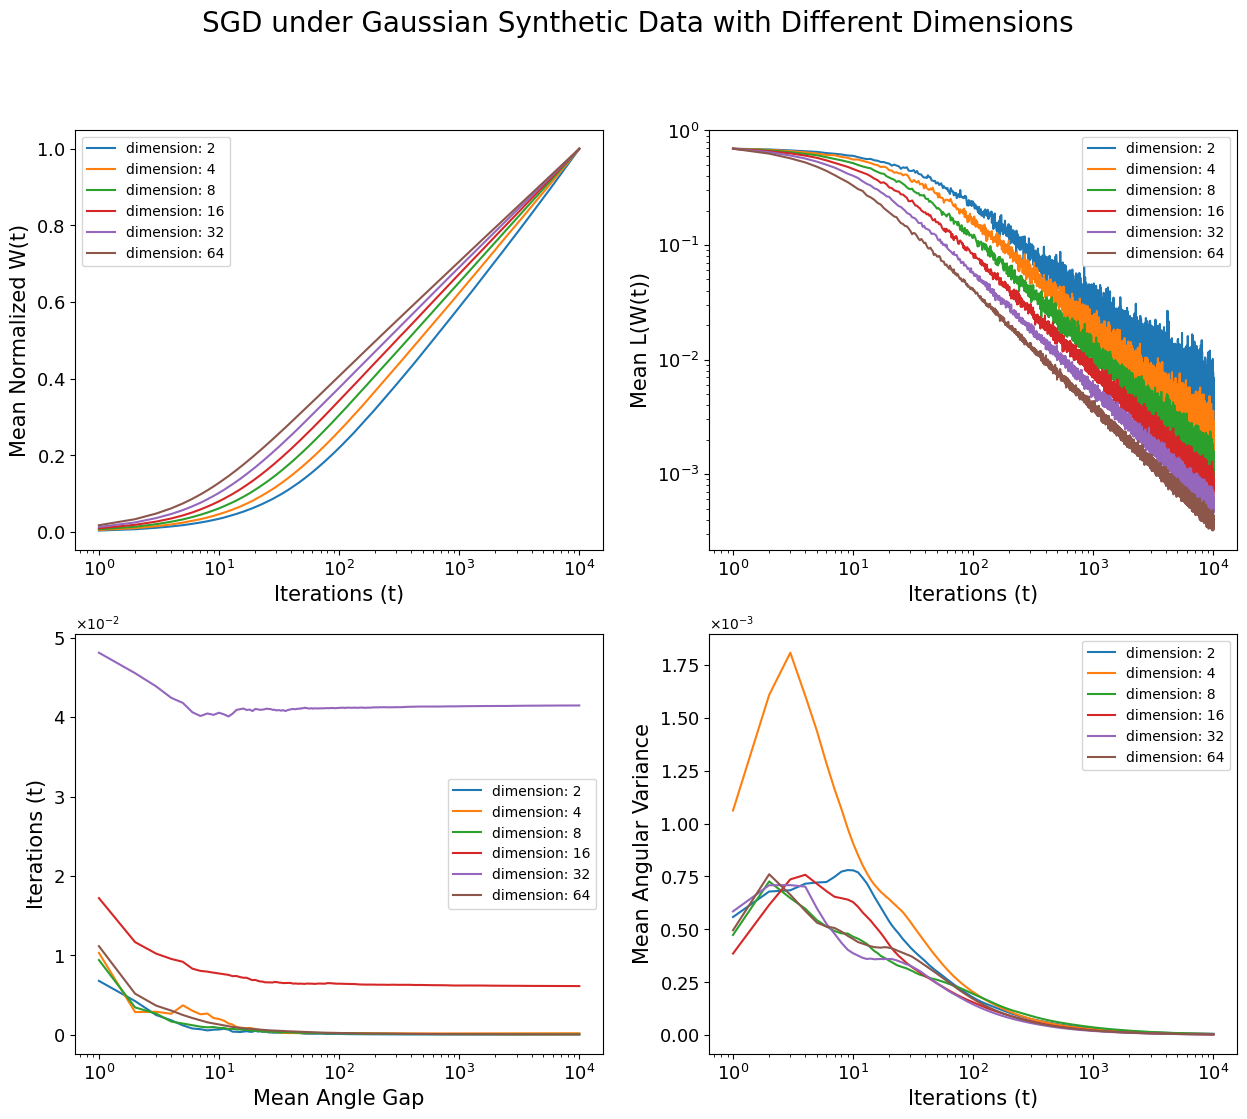

In [ ]:
plot_results(Z, total_param,
             max_margin_vectors,
             total_loss, iterations,
             dimensions, 'dimension',
             'SGD under Gaussian Synthetic Data with Different Dimensions')

# Gaussian Data: Variance

In [ ]:
total_param = []
total_loss = []
max_margin_vectors = []
stds = [0.2,0.4,0.8,1.6]

pbar = tqdm(enumerate(stds), total=len(stds))
for i, test_std in pbar:
  pbar.set_description(desc = f"Currently Processing {i}th Iteration")
  test_means = [[1.5]*2,[-1.5]*2]
  test_covariances = np.identity(2)*(test_std**2)
  test_df = generate_gaussian_blobs(n_samples_per_blob = n_samples_per_blob,
                                    means = test_means,
                                    covariances = test_covariances)

  #check for linear separability and L2 Max Margin Vector
  L2_max_margin = is_linearly_separable(test_df.iloc[:,:-1], test_df['labels'])
  max_margin_vectors.append(L2_max_margin)
  print(f"The test L2 max margin weight is {L2_max_margin}")

  test_Y, test_Z = test_df['labels'].values, test_df.iloc[:,:-1].values
  _, test_singular_values, _ = np.linalg.svd(test_Z)

  test_sgd_loss, test_grad_sgd_loss = make_sgd_robust_loss(test_Y, test_Z, 'logistic')
  test_init_param = np.zeros(2)

  all_param = []
  all_loss = []
  for _ in range(num_test):
    results, losses = run_SGD_modified('constant',
                                      test_sgd_loss,
                                      test_grad_sgd_loss,
                                      test_init_param,
                                      1/np.max(test_singular_values),
                                      eta0,
                                      alpha,
                                      batchsize,
                                      test_Z.shape[0],
                                      iterations,
                                      True)
    all_param.append(results)
    all_loss.append(losses)

  total_param.append(all_param)
  total_loss.append(all_loss)

Currently Processing 0th Iteration:   0%|          | 0/4 [00:00<?, ?it/s]

The data is linearly separable: True	
The test L2 max margin weight is [0.46303177 0.45718002]


Currently Processing 1th Iteration:  25%|██▌       | 1/4 [00:18<00:56, 18.89s/it]

The data is linearly separable: True	
The test L2 max margin weight is [0.71954139 0.72757852]


Currently Processing 2th Iteration:  50%|█████     | 2/4 [00:39<00:39, 19.86s/it]

The data is linearly separable: False	
The test L2 max margin weight is [1.72001064 1.40207422]


Currently Processing 3th Iteration:  75%|███████▌  | 3/4 [00:58<00:19, 19.50s/it]

The data is linearly separable: False	
The test L2 max margin weight is [0.39932456 0.35551969]


Currently Processing 3th Iteration: 100%|██████████| 4/4 [01:17<00:00, 19.32s/it]


Currently Processing 3th Iteration: 100%|██████████| 4/4 [01:11<00:00, 17.99s/it]


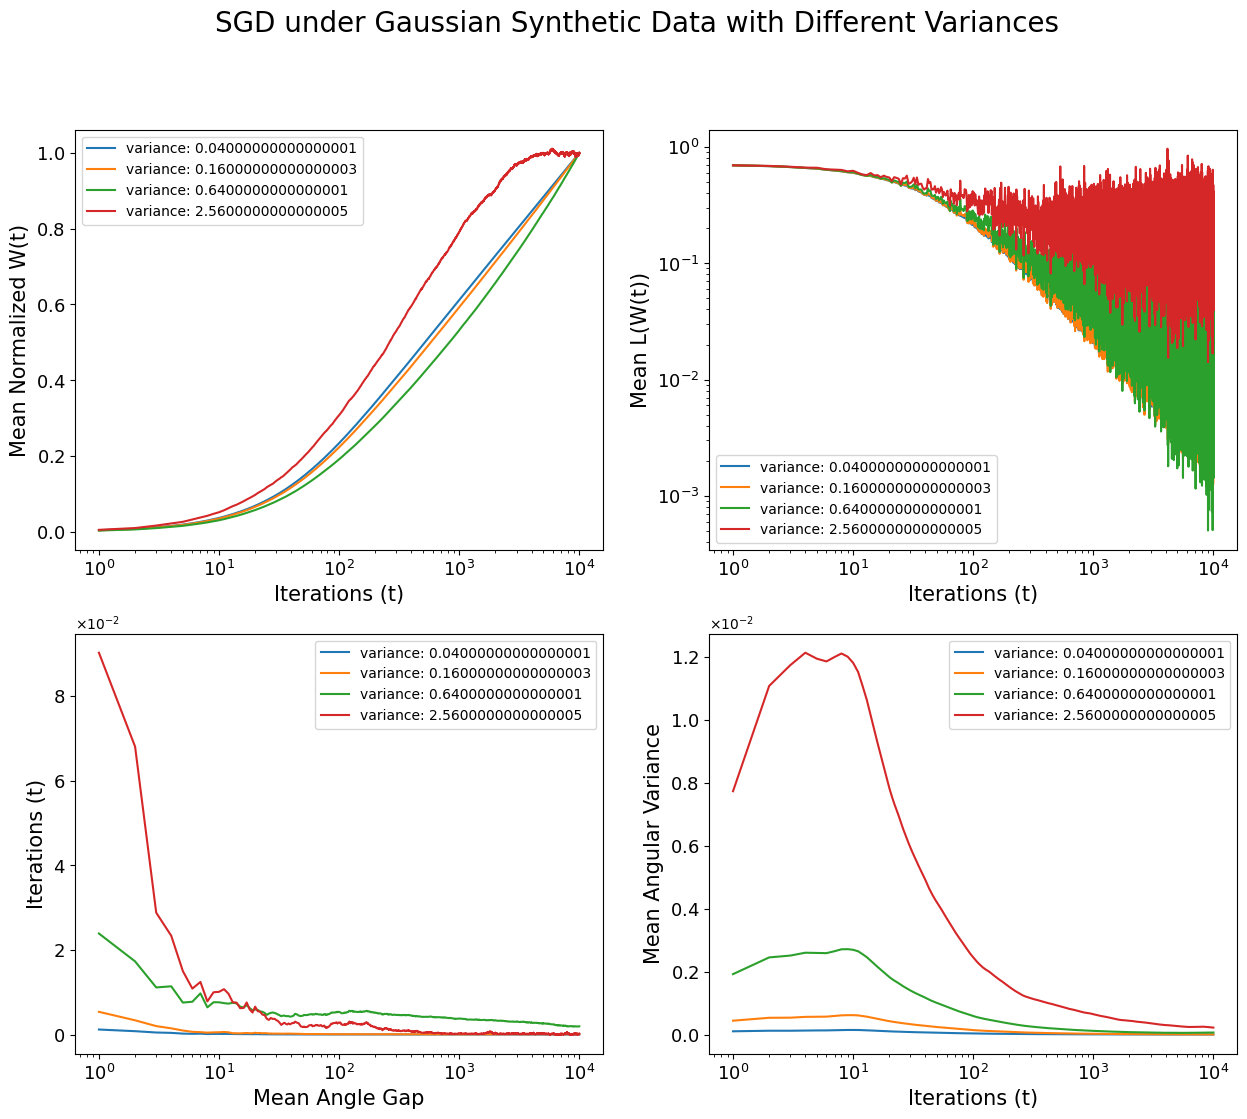

In [ ]:
plot_results(Z, total_param,
             max_margin_vectors,
             total_loss, iterations,
             [i**2 for i in stds], 'variance',
             'SGD under Gaussian Synthetic Data with Different Variances')